## Data
The data in this notebook can be downloaded from that Kaggle webpage at: https://www.kaggle.com/rdoume/beerreviews
It requires Kaggle login so the download can not be included in this notebook.

As of November 27, 2019 this notebook depends on functionality in the 0.4dev branch of umap.  To install that in your python environment use the following command:<BR>
`pip install datashader holoviews`<BR>
`pip install git+https://github.com/lmcinnes/umap.git@0.4dev`
    
At some point in the future this will be merged into the main branch and this notebook will only require:<BR>
`pip install umap-learn`


In [1]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import umap
import umap.plot
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

Loading BokehJS ...

We'd like to turn categorical data into a document of space seperated strings.  We want to do this to keep a nice easy pipeline for sklearns CountVectorizer.  A very natural way to accomplish this is via pandas df.groupby() function with a " ".join(my_array) aggregator passed in.  Unfortunately, it turns out that " ".join(my_array) seems to have trouble on for lists (or sequences) longer than 3,000 or so.  

As such we've included a simple (though not necessarily efficient) join function that scales to large arrays.

In [3]:
def join(iterator, seperator):
    """
    This function casts the elements of iterator to strings then merges those strings together with a string 
    representation of seperator.  
    Had to write a custom join to handle very, very long lists of things. "".join falls appart above 3013.
    params
    iterator: an iterator.  This function makes use of the overload + operator for strings
    seperator: an item of the same class as is contained in our iterator to be added between every pair of instances.
    returns
    The sum of the iterator values with seperator iterposed between each.
    """
    it = map(str, iterator)
    seperator = str(seperator)
    string = next(it, '')
    for s in it:
        string += seperator + s
    return string

### Read in our data

In [4]:
reviews = pd.read_csv('beerreviews_kaggle.zip')
reviews.shape

(1586614, 13)

### Interesting Tidbits:
25% of the beer_beerid have no recorded beer_abv.

In [5]:
reviews.head().T

,0,1,2,3,4
brewery_id,10325,10325,10325,10325,1075
brewery_name,Vecchio Birraio,Vecchio Birraio,Vecchio Birraio,Vecchio Birraio,Caldera Brewing Company
review_time,1234817823,1235915097,1235916604,1234725145,1293735206
review_overall,1.5,3,3,3,4
review_aroma,2,2.5,2.5,3,4.5
review_appearance,2.5,3,3,3.5,4
review_profilename,stcules,stcules,stcules,stcules,johnmichaelsen
beer_style,Hefeweizen,English Strong Ale,Foreign / Export Stout,German Pilsener,American Double / Imperial IPA
review_palate,1.5,3,3,2.5,4
review_taste,1.5,3,3,3,4.5


## Embed Beer

If we are going to embed beer then we need to turn our reviews data frame into a frame with one row per beer instead of one row per review.

This is a job for groupby.  We groupby the column we'd like to embedd and then use agg with a dictionary of column names to aggregation functions to tell it how to summarize the many reviews about a single beer into one record.  Aggregation functions are pretty much any function that takes an iterable and returns a single value.  Median and max are great functions for dealing with numeric fields.  First is handy for a field that you know to be common across for every beer review.  In other words fields that are tied to the beer such as brewery_name or beer_abv.

If we've written a short lambda function to pack a list of categorical values into a space seperated string for later consumption by CountVectorizer.

In [ ]:
a = reviews.groupby('brewery_name').agg({
    'brewery_id':lambda x: len(x.unique()),
})

In [7]:
%%time
unique_join = lambda x: join(x.unique(), " ")
breweries = reviews.groupby('brewery_name').agg({
    'beer_name':lambda x: x.mode(),
    'beer_style':lambda x: x.mode(),
    'beer_abv':'mean',
    'review_aroma':'mean',
    'review_appearance':'mean',
    'review_overall':'mean',
    'review_palate':'mean',
    'review_taste':'mean',
    'review_profilename':[unique_join, len],
    'brewery_id':lambda x: len(x.unique()),
}).reset_index()

breweries.columns = """brewery_name beer_name beer_style beer_abv 
review_aroma review_appearance review_overall review_palate review_taste 
review_profilename_list num_reviewers num_ids""".split()
breweries.shape

CPU times: user 6.82 s, sys: 210 ms, total: 7.03 s
Wall time: 7.39 s


(5742, 12)

It turns out there are a number of breweries with multiple brewery_ids for the same brewery_name.  Upon examining thse breweries they are inevitably chains of brew pubs with multiple locations.  We feel that they should be treated as the same brewery.  Thus we chose to grouop by brewery_name instead of brewery_id.

In [10]:
breweries[breweries.num_ids>1].head(2)

,brewery_name,beer_name,beer_style,beer_abv,review_aroma,review_appearance,review_overall,review_palate,review_taste,review_profilename_list,num_reviewers,num_ids
256,BJ's Restaurant & Brewery,Piranha Pale Ale,American Pale Ale (APA),6.045775,3.586022,3.870968,3.704301,3.827957,3.639785,womencantsail Trilogy31 DoubleJ t0rin0 DM1293 ...,93,4
257,BJ's Restaurant & Brewhouse,Tatonka Stout,American Double / Imperial Stout,6.580139,3.466234,3.698701,3.544156,3.505195,3.548052,DAVIDTHEBANDIT Rizalini Onslow jordanmills Fto...,385,3


In [7]:
breweries.head(2).T

,0,1
brewery_name,'t Hofbrouwerijke,(512) Brewing Company
beer_name,Hofblues,(512) Pecan Porter
beer_style,Belgian Dark Ale,American Porter
beer_abv,6.78919,7.14966
review_aroma,3.78378,4.00164
review_appearance,3.85135,4.05757
review_overall,3.7027,4.06579
review_palate,3.54054,3.95888
review_taste,3.62162,4.05592
review_profilename_list,OttoPeeWee northyorksammy mrfrancis metter98 T...,hopdog gawnphishin AgentZero scottfrie jefe2 m...


In [8]:
breweries.sort_values('num_reviewers', ascending=False)

,brewery_name,beer_name,beer_style,beer_abv,review_aroma,review_appearance,review_overall,review_palate,review_taste,review_profilename_list,num_reviewers
701,Boston Beer Company (Samuel Adams),Samuel Adams Boston Lager,Bock,6.414817,3.593107,3.809299,3.689522,3.641365,3.647171,r0nyn Pahn jmalex LAWDAWG BeerManDan jujubeast...,39444
1963,Dogfish Head Brewery,90 Minute IPA,American Double / Imperial IPA,9.505800,3.916945,3.943763,3.836047,3.895860,3.971350,HappyHourHero WCBCFrank rebelthrower BeaBeerWi...,33839
4950,Stone Brewing Co.,"[Arrogant Bastard Ale, Stone Ruination IPA]",American Strong Ale,8.251897,4.094644,4.152422,4.040268,4.073550,4.150608,Kendo BeardedRiker maxpower hopdog thehillsbar...,33066
4743,Sierra Nevada Brewing Co.,Sierra Nevada Celebration Ale,American IPA,6.908040,3.896682,4.096971,4.056207,3.965184,4.028764,6stringfunk CampusCrew BigD1972 JRed GordonQui...,28751
413,"Bell's Brewery, Inc.",Two Hearted Ale,American Stout,7.559407,3.938331,3.983724,3.973066,3.965484,4.011572,Metalmonk gyllstromk hwwty4 Indybeer BeerBuild...,25191
...,...,...,...,...,...,...,...,...,...,...,...
4674,Science Infuse,Science Infuse Triple Spéciale,Tripel,7.000000,3.500000,3.500000,3.500000,3.500000,3.500000,thierrynantes,1
584,Bir&#371; Alus,Bir&#371; irvenos,Euro Pale Lager,6.000000,2.000000,2.500000,3.500000,4.000000,3.500000,atis,1
581,Birrificio Valscura,Valscura,Belgian Strong Dark Ale,7.000000,3.500000,4.000000,3.500000,4.000000,4.000000,mdfb79,1
1487,Calwer-Eck-Bräu GmbH & Co. KG,Keller-Pils,German Pilsener,4.900000,3.500000,4.000000,4.000000,4.500000,3.500000,wl0307,1


## Embed the data

We are going to vectorize our data and look at the number of categorical values they have in common.  A useful thing to do here is to require each row to have a minimum support before being included.  Filtering this early, will ensure indices line up later on.

This step turns a sequence of space seperated text into a sparse matrix of counts.  One row per row of our data frame and one column per unique token that appeared in our categorical field of interest.

If we want to deal with sets (i.e. just presence or absence of a category) use:<BR>
`beer_by_authors_vectorizer = CountVectorizer(binary=True)`<BR>
If we think counts should matter we might use:<BR>
`beer_by_authors_vectorizer = CountVectorizer()`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
`beer_by_authors_vectorizer = TfidfVectorizer()`<BR>
    
We probably want to remove any brewery that has only a few reviewers.  This threshold can be based on intuition or by examining the distribution of reviews per brewery.
    
We use `min_df=10` in our CountVectorize to only count reviewers who have reviewed at least 10 beers.  


In [38]:
popular_breweries = breweries[breweries.num_reviewers>100].reset_index(drop=True)
brewery_by_authors_vectorizer = CountVectorizer(binary=True, min_df=10)
brewery_by_authors = brewery_by_authors_vectorizer.fit_transform(popular_breweries.review_profilename_list)
brewery_by_authors

<1211x9507 sparse matrix of type '<class 'numpy.int64'>'
	with 561385 stored elements in Compressed Sparse Row format>

Now we reduce the dimension of this data.

If we are dealing with sets (i.e. just presence or absence of a category) use:<BR>
`metric='jaccard'`<BR>
If we think counts should matter we might use:<BR>
`metric='hellinger'`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
`metric='hellinger'`<BR>
    
As you get more and more points I'd recommend increasing the `n_neighbors` parameter to compensate.  Thing of this as a resolution parameter.

`n_components` controls the dimension you will be embedding your data into (2-dimensions for easy visualization).  Feel free to embed into higher dimensions for clustering if you'd like.

`unique=True` says that if you have two identical points you want to map them to the exact same co-ordinates in your low space.  This becomes especially important if you have more exact dupes that your `n_neighbors` parameter.  That is the problem case where exact dupes can be pushed into very different regions of your space.

In [39]:
%%time
brewery_by_authors_model = umap.UMAP(n_neighbors=15, n_components=2, metric='jaccard', min_dist=0.1,
                                  unique=True, random_state=42).fit(brewery_by_authors.todense())

/Users/jchealy/opt/anaconda3/envs/data_science/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1575: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


CPU times: user 12.5 s, sys: 263 ms, total: 12.7 s
Wall time: 12.2 s


In [40]:
outfile ='results/brewery_by_reviewer_jaccard'

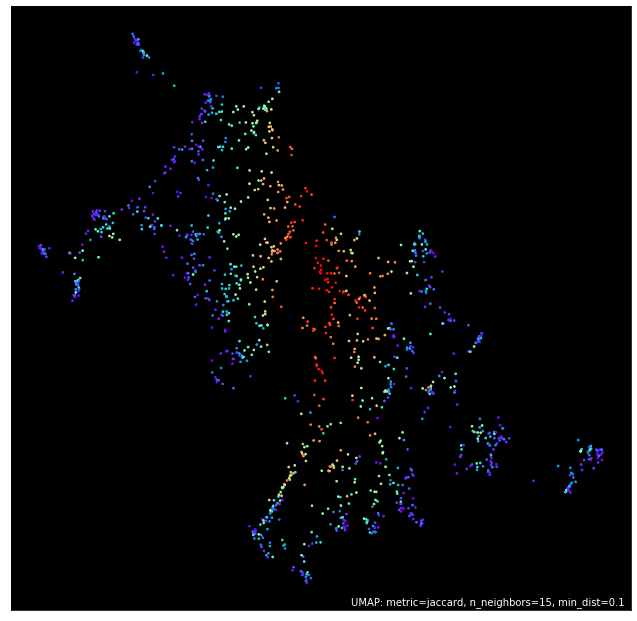

In [44]:
umap_plot = umap.plot.points(brewery_by_authors_model, labels=np.log(popular_breweries.num_reviewers.values), theme='fire');
#umap_plot.figure.savefig(outfile+'.png', dpi=300, bbox_inches='tight')

... and now for an interactive plot with mouseover.

In [46]:
hover_df = popular_breweries['brewery_name beer_style beer_abv num_reviewers review_overall'.split()]
f = umap.plot.interactive(brewery_by_authors_model, labels=np.log(popular_breweries.num_reviewers.values), 
                          hover_data=hover_df, theme='fire', point_size=5);
#save(f,outfile+'.html')
show(f)

Not surprisingly when you embed breweries by their reviewers you end up creating a massive hub in the center where the very popular breweries have been reviewed by everyone.  Then you fragment into the outskirts where less popular breweries tend to be reviewed by locals, thus clustering by geographic regions.